In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
##Load tweet files
df=pd.read_csv('/data/tweets.csv')
rel=pd.read_csv('/data/religion.csv')
autonomy=pd.read_csv('/data/autonomy.csv')
fetal_rights=pd.read_csv('/data/fetal_rights.csv')
health=pd.read_csv('/data/health.csv')
excep=pd.read_csv('/data/exceptions.csv')

In [ ]:
df['date']=df['str_date'].apply(pd.Timestamp)

In [4]:
uncivil=['anger','toxicity_bin','obscene_bin','insult_bin','new_hate']
lib=df[df['political_gen']==0]
con=df[df['political_gen']==1]
lib_mean=lib.groupby('str_date')[uncivil].mean().reset_index()
con_mean=con.groupby('str_date')[uncivil].mean().reset_index()

In [6]:
def smooth(x):
    return x.rolling(window=3, min_periods=1).mean()
def round_time(x):
    return x.replace(hour=(x.hour // 6) * 6, minute=0, second=0, microsecond=0)
def str_date(x):
    return datetime.strftime(x,"%Y-%m-%d")

In [8]:
tqdm.pandas()
df['full_date']=df['created_at'].progress_apply(pd.Timestamp)
df['full_date']=df['full_date'].progress_apply(round_time)

100%|██████████| 3546065/3546065 [00:14<00:00, 248941.56it/s]


## Interrupted Time Series - Use of Hostile Expression 

In [11]:
all_events={}
all_pvalues={}
event_dates=[pd.Timestamp('2022-05-03'),pd.Timestamp('2022-06-24'),pd.Timestamp('2022-08-02'),pd.Timestamp('2022-11-08')]
for e in tqdm(event_dates):
    event={'lib':{},'con':{}}
    pvalues={'lib':{},'con':{}}
    low=e-timedelta(7)
    high=e+timedelta(7)
    df['date']=df['str_date'].apply(pd.Timestamp)
    d=df[(df['date']>=low)&(df['date']<=high)]

    l=d[d['political_gen']==0]
    c=d[d['political_gen']==1]
    
    l=l.groupby('full_date')[uncivil].mean().reset_index()
    c=c.groupby('full_date')[uncivil].mean().reset_index()
    
    l['str_date']=l['full_date'].apply(str_date)
    c['str_date']=c['full_date'].apply(str_date)
    day_num={}
    s=0
    for i in list(l['str_date'].unique()):
        day_num[i]=s
        s+=1
        

    l['day']=l['str_date'].map(day_num)
    c['day']=c['str_date'].map(day_num)

    l_d=[0 if pd.Timestamp(d) < e else 1 for d in l['str_date'].tolist()]
    c_d=[0 if pd.Timestamp(d) < e else 1 for d in c['str_date'].tolist()]

    l['event']=l_d
    c['event']=c_d

    #diff=len(l[l['full_date']<e])
    diff=(e-low).days
    l['days_after']=l['day']-diff
    c['days_after']=c['day']-diff

    l['days_after']=l['days_after'].apply(lambda a: max(0, a))
    c['days_after']=c['days_after'].apply(lambda a: max(0, a))

    for u in uncivil:
        model_l=sm.OLS(l[u], sm.add_constant(l[['day', 'event', 'days_after']]))
        model_c=sm.OLS(c[u], sm.add_constant(c[['day', 'event', 'days_after']]))
        results_l = model_l.fit()
        results_c = model_c.fit()

        event['lib'][u]=results_l.params['event']
        event['con'][u]=results_c.params['event']

        pvalues['lib'][u]=results_l.pvalues['event']
        pvalues['con'][u]=results_c.pvalues['event']
    all_events[datetime.strftime(e,"%Y-%m-%d")]=event
    all_pvalues[datetime.strftime(e,"%Y-%m-%d")]=pvalues

100%|██████████| 4/4 [00:47<00:00, 11.92s/it]


In [12]:
for date in all_events:
    for ideo in all_events[date]:
        for u in all_events[date][ideo]:
            if all_pvalues[date][ideo][u]<=0.05 and all_pvalues[date][ideo][u]>=0.01:
                all_events[date][ideo][u]='*\n'+str(np.round(all_events[date][ideo][u],2))
            elif all_pvalues[date][ideo][u]<0.01 and all_pvalues[date][ideo][u]>=0.001:
                all_events_con[date][ideo][u]='**\n'+str(np.round(all_events[date][ideo][u],2))
            elif all_pvalues[date][ideo][u]<0.001 and all_pvalues[date][ideo][u]>=0.0001:
                all_events[date][ideo][u]='***\n'+str(np.round(all_events[date][ideo][u],2))
            elif all_pvalues[date][ideo][u]<0.0001:
                all_events[date][ideo][u]='****\n'+str(np.round(all_events[date][ideo][u],2))
            else:
                all_events[date][ideo][u]=str(np.round(all_events[date][ideo][u],2))

2022-05-03


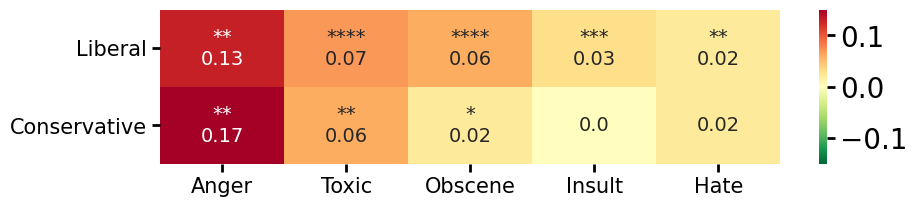

2022-06-24


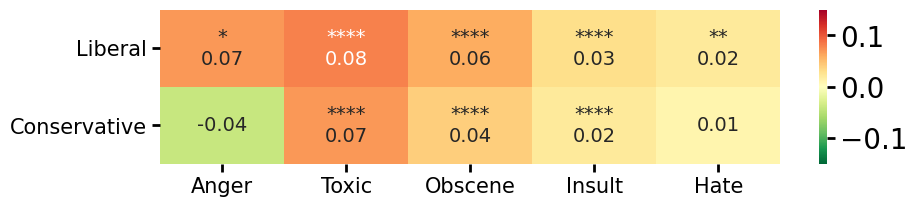

2022-08-02


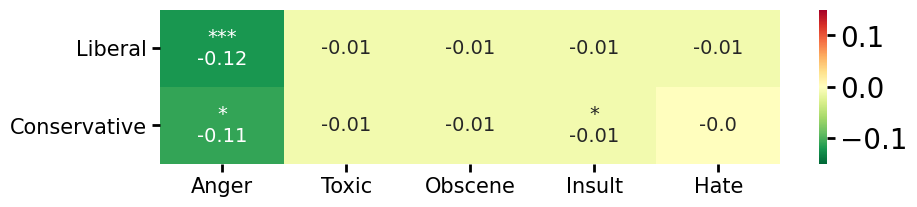

2022-11-08


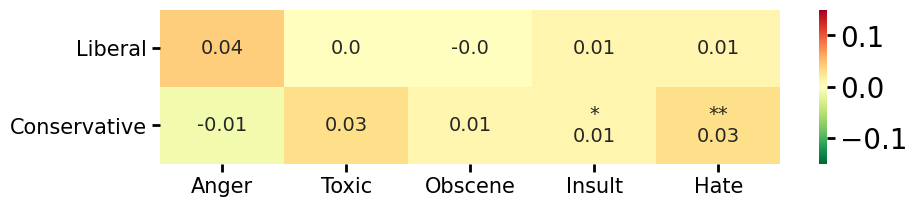

In [27]:
titles=['leak','official','kansas','midterms']
ct=0
for event in all_events:
    print(event)
    affect=['Ideology','Anger','Toxic','Obscene','Insult','Hate']
    plt.rcParams['axes.grid'] = False
    
    l=list(all_events[event]['lib'].values())
    l=[float(x.replace('*','').replace('\n','')) for x in l]
    
    c=list(all_events[event]['con'].values())
    c=[float(x.replace('*','').replace('\n','')) for x in c]
    lib=['Liberal']+l
    cons=['Conservative']+c
    
    tmp=pd.DataFrame(columns=affect,data=[lib,cons])
    tmp['Ideology']=['Liberal','Conservative']
    tmp.index=tmp['Ideology'].tolist()
    del tmp['Ideology']
    plt.figure(figsize=(10,2))
    lib=list(all_events[event]['lib'].values())
    cons=list(all_events[event]['con'].values())
    annot=[lib,cons]
    ax=sns.heatmap(tmp,vmin=-0.15,vmax=0.15,cmap='RdYlGn_r',annot=annot,fmt='',annot_kws={"fontsize":14})
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15,rotation=0)
    plt.tick_params(axis='both',length=6,width=2)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(axis='both',length=6,width=2,labelsize=20)
    plt.savefig('itsa_'+titles[ct]+'_uncivil_6h.pdf',bbox_inches='tight',dpi=300)
    ct+=1
    plt.show()

In [19]:
ylims={'anger':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],
      'toxicity_bin':[0,0.03,0.06,0.09,0.12,0.15,0.18],
      'new_hate':[0,0.04,0.08,0.12,0.16,0.20],
      'insult_bin':[0,0.02,0.04,0.06,0.08],
      'obscene_bin':[0,0.02,0.04,0.06,0.08,0.10]}

In [26]:
all_events={}
all_pvalues={}
event_names=['leak','ruling','kansas','midterms']
ec=0
event_dates=[pd.Timestamp('2022-05-03'),pd.Timestamp('2022-06-24'),pd.Timestamp('2022-08-02'),pd.Timestamp('2022-11-08')]
for e in tqdm(event_dates):
    event={'lib':{},'con':{}}
    pvalues={'lib':{},'con':{}}
    low=e-timedelta(7)
    high=e+timedelta(7)
    df['date']=df['str_date'].apply(pd.Timestamp)
    d=df[(df['date']>=low)&(df['date']<=high)]

    l=d[d['political_gen']==0]
    c=d[d['political_gen']==1]
    
    l=l.groupby('full_date')[uncivil].mean().reset_index()
    c=c.groupby('full_date')[uncivil].mean().reset_index()
    
    l['str_date']=l['full_date'].apply(str_date)
    c['str_date']=c['full_date'].apply(str_date)
    day_num={}
    s=0
    for i in list(l['str_date'].unique()):
        day_num[i]=s
        s+=1
        

    l['day']=l['str_date'].map(day_num)
    c['day']=c['str_date'].map(day_num)

    l_d=[0 if pd.Timestamp(d) < e else 1 for d in l['str_date'].tolist()]
    c_d=[0 if pd.Timestamp(d) < e else 1 for d in c['str_date'].tolist()]

    l['event']=l_d
    c['event']=c_d

    diff=(e-low).days
    l['days_after']=l['day']-diff
    c['days_after']=c['day']-diff

    l['days_after']=l['days_after'].apply(lambda a: max(0, a))
    c['days_after']=c['days_after'].apply(lambda a: max(0, a))
    
    
    
    for u in uncivil:
        plt.figure(figsize=(5,5))
        l_before=l[l['event']==0]
        l_after=l[l['event']==1]

        c_before=c[c['event']==0]
        c_after=c[c['event']==1]
        plt.axvline(7,color='black',lw=1.5,linestyle='-.',label=event_names[ec])
        
        sns.regplot(l_before['day'],l_before[u],color='skyblue',scatter_kws={'s':100,'alpha':0.5},label='Lib. Before')
        sns.regplot(l_after['day'],l_after[u],color='steelblue',scatter_kws={'s':100,'alpha':0.5},label='Lib. After')

        sns.regplot(c_before['day'],c_before[u],color='#F88379',scatter_kws={'s':100,'alpha':0.5},label='Cons. Before')
        sns.regplot(c_after['day'],c_after[u],color='red',scatter_kws={'s':100,'alpha':0.5},label='Cons. After')

        plt.xlabel(None)
        plt.ylabel(None)
        plt.xticks(fontsize=25)
        plt.yticks(ylims[u],fontsize=25)
        plt.ylim([min(ylims[u]),max(ylims[u])])
        plt.savefig(event_names[ec]+'_'+u+'.pdf',dpi=300,bbox_inches='tight')
    ec+=1

100%|██████████| 4/4 [01:21<00:00, 20.40s/it]


## Interrupted Time Series - Use of Frames

In [11]:
rel=rel[rel['id'].isin(df['id'].tolist())]
autonomy=autonomy[autonomy['id'].isin(df['id'].tolist())]
fetal_rights=fetal_rights[fetal_rights['id'].isin(df['id'].tolist())]
health=health[health['id'].isin(df['id'].tolist())]
excep=excep[excep['id'].isin(df['id'].tolist())]

In [12]:
uncivil=['anger','toxicity_bin','obscene_bin','insult_bin','new_hate']

In [13]:
def smooth(x):
    return x.rolling(window=3, min_periods=1).mean()
def str_date(x):
    return datetime.strftime(x,"%Y-%m-%d")
def round_time(x):
    return x.replace(hour=(x.hour // 6) * 6, minute=0, second=0, microsecond=0)

In [31]:
day_counts=df[['id','str_date','political_gen']].groupby(['str_date','political_gen']).size().reset_index(name='total')
rel_count=rel[['id','str_date','political_gen']].groupby(['str_date','political_gen']).size().reset_index(name='count')
autonomy_count=autonomy[['id','str_date','political_gen']].groupby(['str_date','political_gen']).size().reset_index(name='count')
fetal_rights_count=fetal_rights[['id','str_date','political_gen']].groupby(['str_date','political_gen']).size().reset_index(name='count')
health_count=health[['id','str_date','political_gen']].groupby(['str_date','political_gen']).size().reset_index(name='count')
excep_count=excep[['id','str_date','political_gen']].groupby(['str_date','political_gen']).size().reset_index(name='count')

In [32]:
rel_count=rel_count.merge(day_counts,on=['str_date','political_gen'])
autonomy_count=autonomy_count.merge(day_counts,on=['str_date','political_gen'])
fetal_rights_count=fetal_rights_count.merge(day_counts,on=['str_date','political_gen'])
health_count=health_count.merge(day_counts,on=['str_date','political_gen'])
excep_count=excep_count.merge(day_counts,on=['str_date','political_gen'])

In [33]:
rel_count['frac']=rel_count['count']/rel_count['total']
autonomy_count['frac']=autonomy_count['count']/autonomy_count['total']
fetal_rights_count['frac']=fetal_rights_count['count']/fetal_rights_count['total']
health_count['frac']=health_count['count']/health_count['total']
excep_count['frac']=excep_count['count']/excep_count['total']

In [34]:
rel_count['date']=rel_count['str_date'].apply(pd.Timestamp)
autonomy_count['date']=autonomy_count['str_date'].apply(pd.Timestamp)
fetal_rights_count['date']=fetal_rights_count['str_date'].apply(pd.Timestamp)
health_count['date']=health_count['str_date'].apply(pd.Timestamp)
excep_count['date']=excep_count['str_date'].apply(pd.Timestamp)

In [16]:
tqdm.pandas()
df['full_date']=df['created_at'].progress_apply(pd.Timestamp)
df['full_date']=df['full_date'].progress_apply(round_time)

100%|██████████| 3546065/3546065 [00:27<00:00, 126858.94it/s]


In [17]:
rel=pickle.load(open('/data/religion.pkl','rb'))
autonomy=pickle.load(open('/data/autonomy.pkl','rb'))
fetal_rights=pickle.load(open('/data/fetal_rights.pkl','rb'))
health=pickle.load(open('/data/health.pkl','rb'))
excep=pickle.load(open('/data/exceptions.pkl','rb'))

In [18]:
rel=rel.merge(df[['id','full_date']],on='id')
autonomy=autonomy.merge(df[['id','full_date']],on='id')
fetal_rights=fetal_rights.merge(df[['id','full_date']],on='id')
health=health.merge(df[['id','full_date']],on='id')
excep=excep.merge(df[['id','full_date']],on='id')

In [19]:
lib_df=df[df['political_gen']==0]
con_df=df[df['political_gen']==1]

lib_rel=rel[rel['political_gen']==0]
con_rel=rel[rel['political_gen']==1]

lib_autonomy=autonomy[autonomy['political_gen']==0]
con_autonomy=autonomy[autonomy['political_gen']==1]

lib_fetal_rights=fetal_rights[fetal_rights['political_gen']==0]
con_fetal_rights=fetal_rights[fetal_rights['political_gen']==1]

lib_health=health[health['political_gen']==0]
con_health=health[health['political_gen']==1]

lib_excep=excep[excep['political_gen']==0]
con_excep=excep[excep['political_gen']==1]

In [25]:
lib_day_counts=lib_df[['id','full_date']].groupby(['full_date']).size().reset_index(name='total')
lib_rel_count=lib_rel[['id','full_date']].groupby(['full_date']).size().reset_index(name='count')
lib_autonomy_count=lib_autonomy[['id','full_date']].groupby(['full_date']).size().reset_index(name='count')
lib_fetal_rights_count=lib_fetal_rights[['id','full_date']].groupby(['full_date']).size().reset_index(name='count')
lib_health_count=lib_health[['id','full_date']].groupby(['full_date']).size().reset_index(name='count')
lib_excep_count=lib_excep[['id','full_date']].groupby(['full_date']).size().reset_index(name='count')

In [26]:
con_day_counts=con_df[['id','full_date']].groupby(['full_date']).size().reset_index(name='total')
con_rel_count=con_rel[['id','full_date']].groupby(['full_date']).size().reset_index(name='count')
con_autonomy_count=con_autonomy[['id','full_date']].groupby(['full_date']).size().reset_index(name='count')
con_fetal_rights_count=con_fetal_rights[['id','full_date']].groupby(['full_date']).size().reset_index(name='count')
con_health_count=con_health[['id','full_date']].groupby(['full_date']).size().reset_index(name='count')
con_excep_count=con_excep[['id','full_date']].groupby(['full_date']).size().reset_index(name='count')

In [27]:
lib_rel_count=lib_rel_count.merge(lib_day_counts,on=['full_date'])
lib_autonomy_count=lib_autonomy_count.merge(lib_day_counts,on=['full_date'])
lib_fetal_rights_count=lib_fetal_rights_count.merge(lib_day_counts,on=['full_date'])
lib_health_count=lib_health_count.merge(lib_day_counts,on=['full_date'])
lib_excep_count=lib_excep_count.merge(lib_day_counts,on=['full_date'])

In [28]:
con_rel_count=con_rel_count.merge(con_day_counts,on=['full_date'])
con_autonomy_count=con_autonomy_count.merge(con_day_counts,on=['full_date'])
con_fetal_rights_count=con_fetal_rights_count.merge(con_day_counts,on=['full_date'])
con_health_count=con_health_count.merge(con_day_counts,on=['full_date'])
con_excep_count=con_excep_count.merge(con_day_counts,on=['full_date'])

In [29]:
lib_rel_count['frac']=lib_rel_count['count']/lib_rel_count['total']
lib_autonomy_count['frac']=lib_autonomy_count['count']/lib_autonomy_count['total']
lib_fetal_rights_count['frac']=lib_fetal_rights_count['count']/lib_fetal_rights_count['total']
lib_health_count['frac']=lib_health_count['count']/lib_health_count['total']
lib_excep_count['frac']=lib_excep_count['count']/lib_excep_count['total']

In [30]:
con_rel_count['frac']=con_rel_count['count']/con_rel_count['total']
con_autonomy_count['frac']=con_autonomy_count['count']/con_autonomy_count['total']
con_fetal_rights_count['frac']=con_fetal_rights_count['count']/con_fetal_rights_count['total']
con_health_count['frac']=con_health_count['count']/con_health_count['total']
con_excep_count['frac']=con_excep_count['count']/con_excep_count['total']

In [32]:
lib_rel_count['str_date']=lib_rel_count['full_date'].apply(str_date)
lib_autonomy_count['str_date']=lib_autonomy_count['full_date'].apply(str_date)
lib_fetal_rights_count['str_date']=lib_fetal_rights_count['full_date'].apply(str_date)
lib_health_count['str_date']=lib_health_count['full_date'].apply(str_date)
lib_excep_count['str_date']=lib_excep_count['full_date'].apply(str_date)

In [33]:
con_rel_count['str_date']=con_rel_count['full_date'].apply(str_date)
con_autonomy_count['str_date']=con_autonomy_count['full_date'].apply(str_date)
con_fetal_rights_count['str_date']=con_fetal_rights_count['full_date'].apply(str_date)
con_health_count['str_date']=con_health_count['full_date'].apply(str_date)
con_excep_count['str_date']=con_excep_count['full_date'].apply(str_date)

In [ ]:
data_list=[lib_rel_count,
lib_autonomy_count,
lib_fetal_rights_count,
lib_health_count,
lib_excep_count]

names=['rel','autonomy','fetal_rights','health','excep']

all_events={}

event_dates=[pd.Timestamp('2022-05-03'),pd.Timestamp('2022-06-24'),pd.Timestamp('2022-08-02'),pd.Timestamp('2022-11-15')]

for e in event_dates:
    event={}
    pvalues={}
    for name in names:
        event[name]={}
        pvalues[name]={}
    low=e-timedelta(7)
    high=e+timedelta(7)
    ct=0
    for l in data_list:
        l['date']=l['str_date'].apply(pd.Timestamp)
        l=l[(l['date']>=low)&(l['date']<=high)]
        day_num={}
        s=0
        for i in list(l['str_date'].unique()):
            day_num[i]=s
            s+=1

        l['day']=l['str_date'].map(day_num)

        l_d=[0 if pd.Timestamp(d) < e else 1 for d in l['str_date'].tolist()]
        
        l['event']=l_d
        
        diff=(e - low).days
        l['days_after']=l['day']-diff
        
        l['days_after']=l['days_after'].apply(lambda a: max(0, a))
        #print(l[l['event']==0]['frac'].mean(),l[l['event']==1]['frac'].mean())
        model_l=sm.OLS(l['frac'], sm.add_constant(l[['day', 'event', 'days_after']]))
        results_l = model_l.fit()
        
        event[names[ct]]['lib']=results_l.params['event']

        pvalues[names[ct]]['lib']=results_l.pvalues['event']
        ct+=1
    for name in event:
        for ideo in event[name]:
            if pvalues[name][ideo]<0.05 and pvalues[name][ideo]>=0.01:
                event[name][ideo]='*\n'+str(np.round(event[name][ideo],2))
            elif pvalues[name][ideo]<0.01 and pvalues[name][ideo]>=0.001:
                event[name][ideo]='**\n'+str(np.round(event[name][ideo],2))
            elif pvalues[name][ideo]<0.001 and pvalues[name][ideo]>=0.0001:
                event[name][ideo]='***\n'+str(np.round(event[name][ideo],2))
            elif pvalues[name][ideo]<0.0001:
                event[name][ideo]='****\n'+str(np.round(event[name][ideo],2))
            else:
                event[name][ideo]=str(np.round(event[name][ideo],2))
    all_events[datetime.strftime(e,"%Y-%m-%d")]=(event)

In [ ]:
data_list=[con_rel_count,
con_autonomy_count,
con_fetal_rights_count,
con_health_count,
con_excep_count]

names=['rel','autonomy','fetal_rights','health','excep']

all_events_con={}

event_dates=[pd.Timestamp('2022-05-03'),pd.Timestamp('2022-06-24'),pd.Timestamp('2022-08-02'),pd.Timestamp('2022-11-15')]

for e in event_dates:
    event={}
    pvalues={}
    for name in names:
        event[name]={}
        pvalues[name]={}
    low=e-timedelta(7)
    high=e+timedelta(7)
    ct=0
    for l in data_list:
        l['date']=l['str_date'].apply(pd.Timestamp)
        l=l[(l['date']>=low)&(l['date']<=high)]
        day_num={}
        s=0
        for i in list(l['str_date'].unique()):
            day_num[i]=s
            s+=1

        l['day']=l['str_date'].map(day_num)

        l_d=[0 if pd.Timestamp(d) < e else 1 for d in l['str_date'].tolist()]
        
        l['event']=l_d
        
        diff=(e - low).days
        l['days_after']=l['day']-diff
        
        l['days_after']=l['days_after'].apply(lambda a: max(0, a))
        print(l[l['event']==0]['frac'].mean(),l[l['event']==1]['frac'].mean())
        model_l=sm.OLS(l['frac'], sm.add_constant(l[['day', 'event', 'days_after']]))
        results_l = model_l.fit()
        
        event[names[ct]]['con']=results_l.params['event']

        pvalues[names[ct]]['con']=results_l.pvalues['event']
        ct+=1
    for name in event:
        for ideo in event[name]:
            if pvalues[name][ideo]<0.05 and pvalues[name][ideo]>=0.01:
                event[name][ideo]='*\n'+str(np.round(event[name][ideo],2))
            elif pvalues[name][ideo]<0.01 and pvalues[name][ideo]>=0.001:
                event[name][ideo]='**\n'+str(np.round(event[name][ideo],2))
            elif pvalues[name][ideo]<0.001 and pvalues[name][ideo]>=0.0001:
                event[name][ideo]='***\n'+str(np.round(event[name][ideo],2))
            elif pvalues[name][ideo]<0.0001:
                event[name][ideo]='****\n'+str(np.round(event[name][ideo],2))
            else:
                event[name][ideo]=str(np.round(event[name][ideo],2))
    all_events_con[datetime.strftime(e,"%Y-%m-%d")]=(event)

In [42]:
final={}
for e in all_events:
    final[e]={}
    for c in all_events[e]:
        if c not in final[e]:
            final[e][c]={}
        final[e][c]['lib']=all_events[e][c]['lib']
        final[e][c]['con']=all_events_con[e][c]['con']

2022-05-03


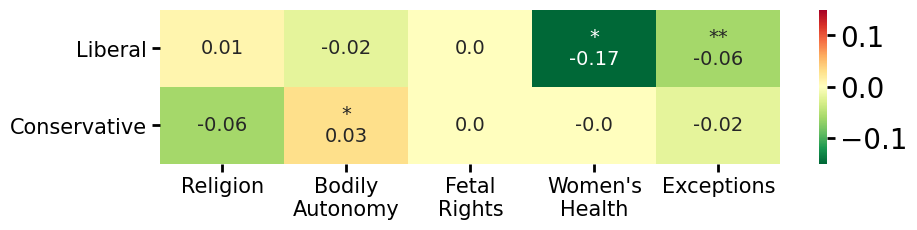

2022-06-24


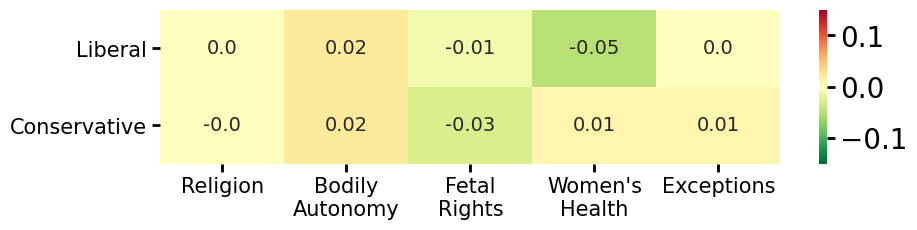

2022-08-02


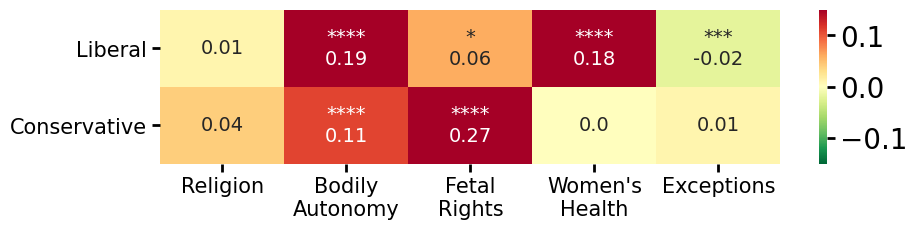

2022-11-08


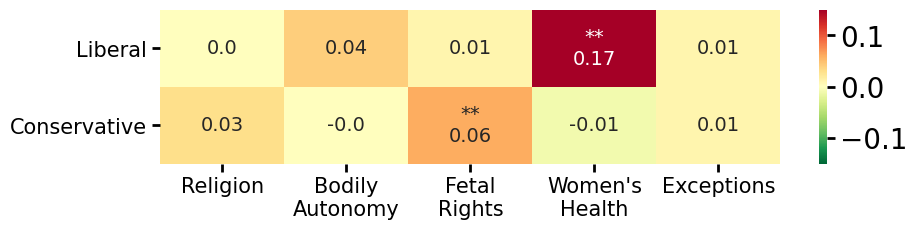

In [44]:
titles=['leak','official','kansas','midterms']
ct=0
for event in final:
    print(event)
    affect=['Ideology','Religion','Bodily\nAutonomy','Fetal\nRights',"Women's\nHealth",'Exceptions']
    plt.rcParams['axes.grid'] = False
    
    l=[]
    c=[]

    l=[final[event][concern]['lib'] for concern in final[event]]
    l=[float(x.replace('*','').replace('\n','')) for x in l]
    
    c=[final[event][concern]['con'] for concern in final[event]]
    c=[float(x.replace('*','').replace('\n','')) for x in c]
   
    lib=['Liberal']+l
    cons=['Conservative']+c

    tmp=pd.DataFrame(columns=affect,data=[lib,cons])
    tmp['Ideology']=['Liberal','Conservative']
    tmp.index=tmp['Ideology'].tolist()
    del tmp['Ideology']
    plt.figure(figsize=(10,2))
    lib=[final[event][concern]['lib'] for concern in final[event]]
    cons=[final[event][concern]['con'] for concern in final[event]]
    annot=[lib,cons]
    ax=sns.heatmap(tmp,vmin=-0.15,vmax=0.15,cmap='RdYlGn_r',annot=annot,fmt='',annot_kws={"fontsize":14})
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15,rotation=0)
    plt.tick_params(axis='both',length=6,width=2)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(axis='both',length=6,width=2,labelsize=20)
    plt.savefig('itsa_'+titles[ct]+'_frame_6h.pdf',bbox_inches='tight',dpi=300)
    ct+=1
    plt.show()

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

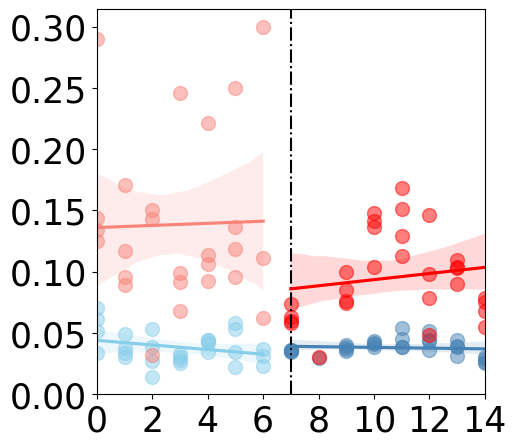

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

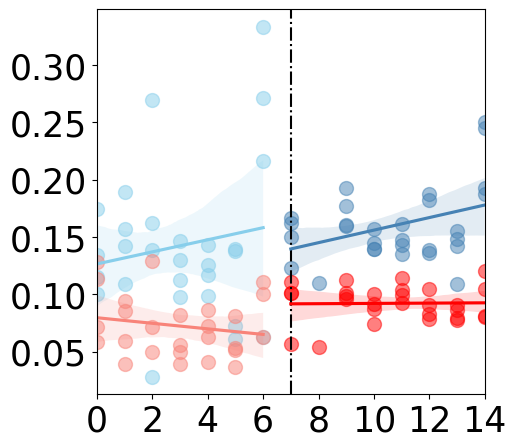

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

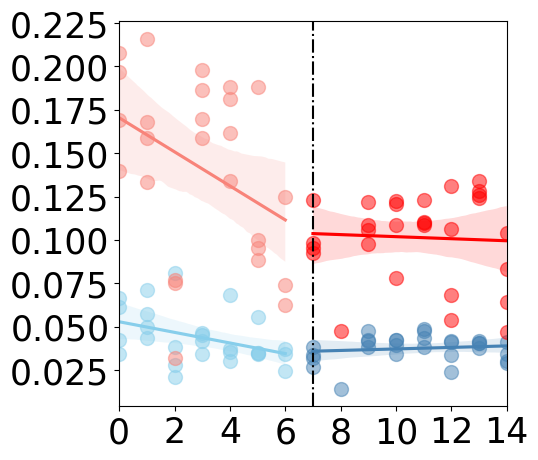

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

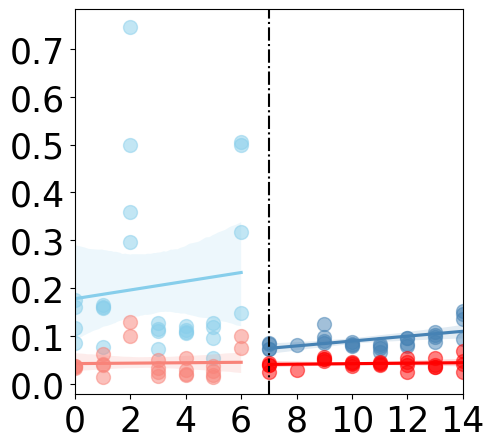

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

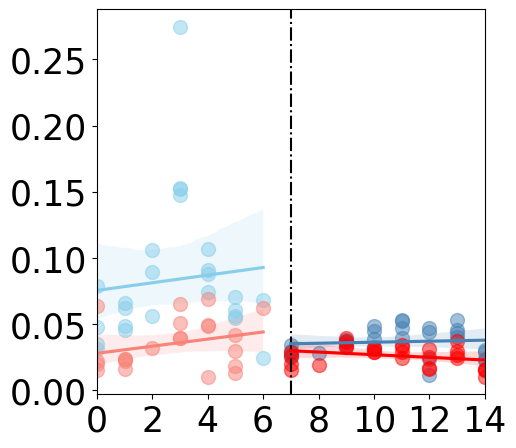

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

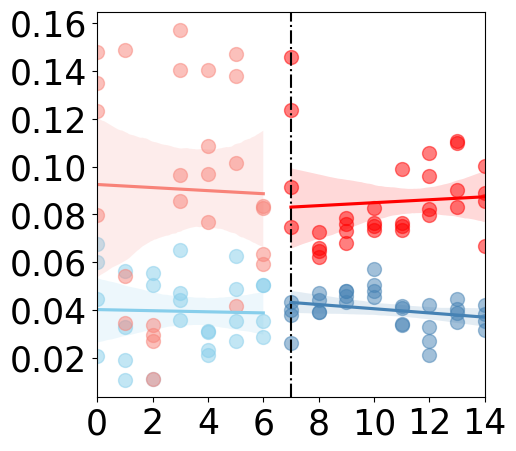

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

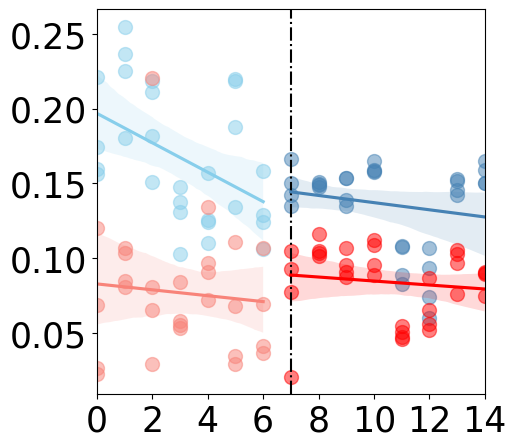

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

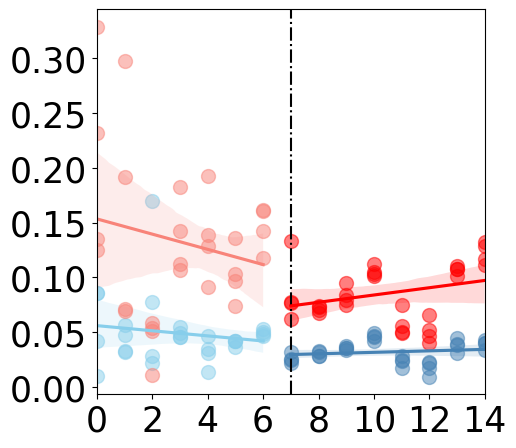

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

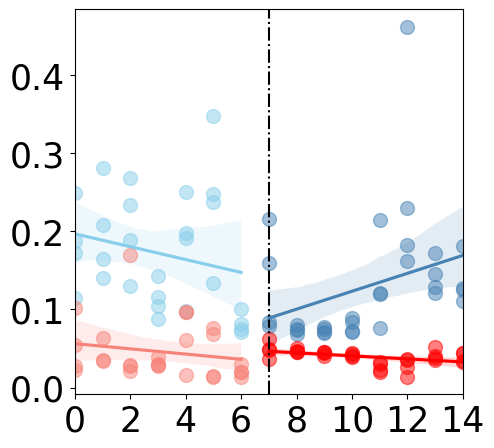

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

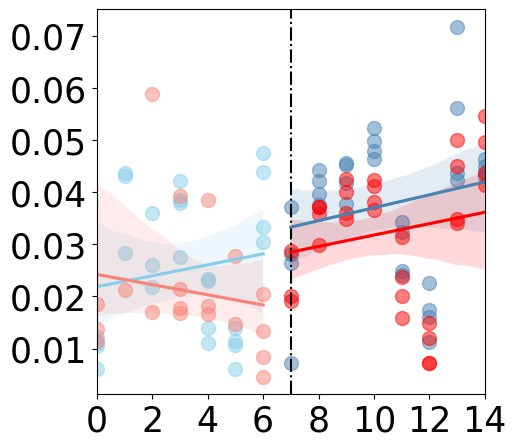

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

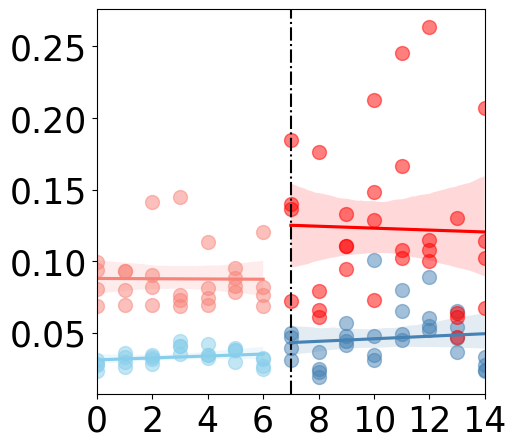

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

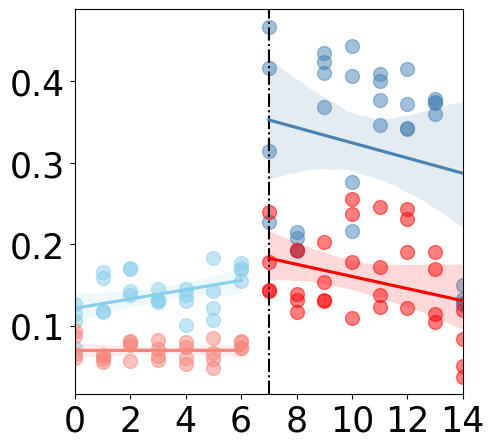

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

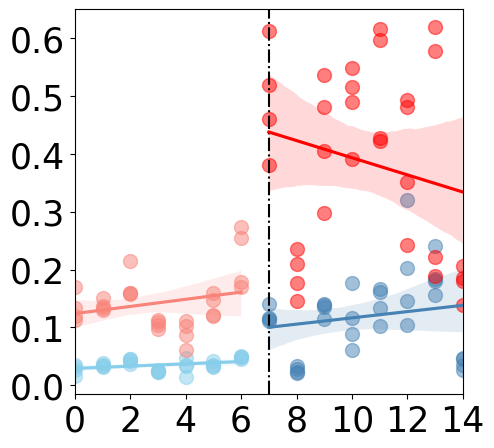

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

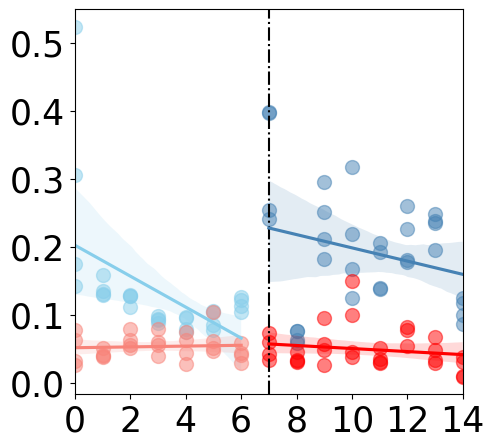

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

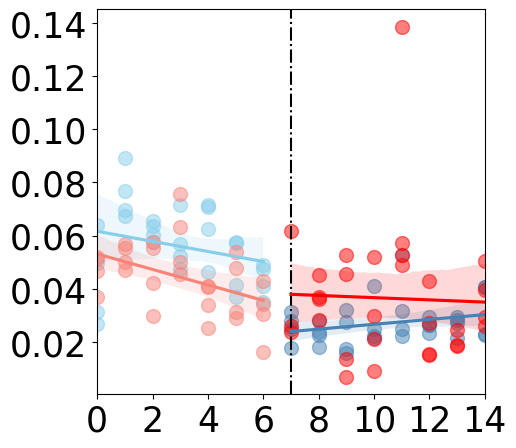

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

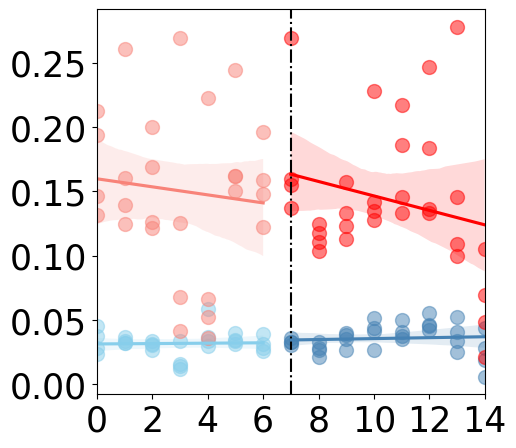

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

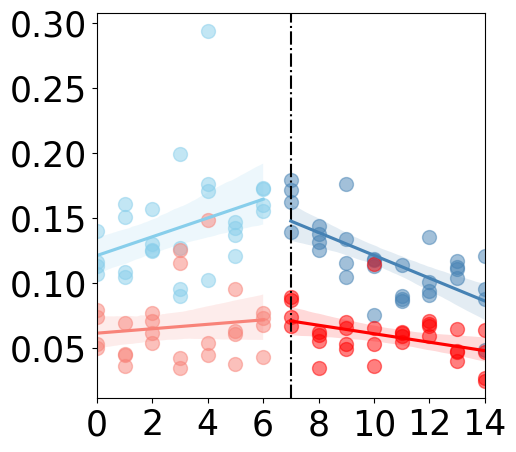

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

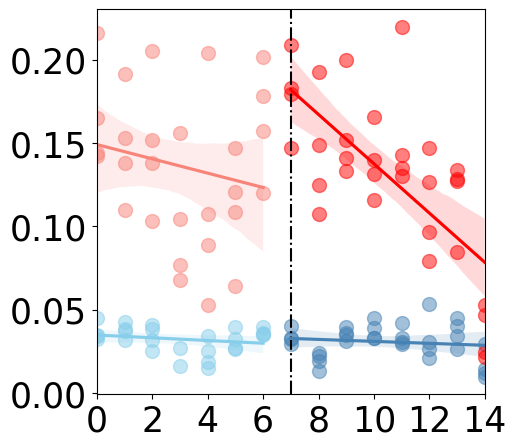

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

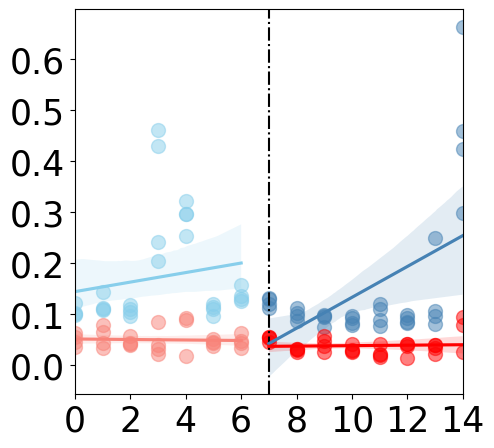

<ipython-input-81-ff428772cf8a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['day']=l['str_date'].map(day_num)
<ipython-input-81-ff428772cf8a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l['event']=l_d
<ipython-input-81-ff428772cf8a>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

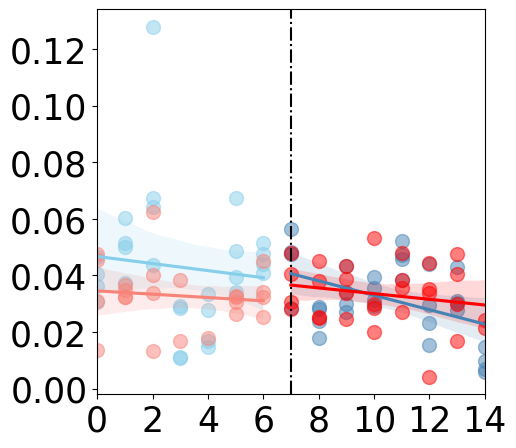

In [81]:
lib_data_list=[lib_rel_count,
lib_autonomy_count,
lib_fetal_rights_count,
lib_health_count,
lib_excep_count]

con_data_list=[con_rel_count,
con_autonomy_count,
con_fetal_rights_count,
con_health_count,
con_excep_count]

names=['rel','autonomy','fetal_rights','health','excep']
event_names=['leak','ruling','kansas','midterms']
ec=0
all_events={}

event_dates=[pd.Timestamp('2022-05-03'),pd.Timestamp('2022-06-24'),pd.Timestamp('2022-08-02'),pd.Timestamp('2022-11-08')]

for e in event_dates:
    event={}
    pvalues={}
    for name in names:
        event[name]={}
        pvalues[name]={}
    low=e-timedelta(7)
    high=e+timedelta(7)
    ct=0
    for j in range(len(lib_data_list)):
        l=lib_data_list[j]
        c=con_data_list[j]
        
        l['date']=l['str_date'].apply(pd.Timestamp)
        l=l[(l['date']>=low)&(l['date']<=high)]
        day_num={}
        s=0
        for i in list(l['str_date'].unique()):
            day_num[i]=s
            s+=1

        l['day']=l['str_date'].map(day_num)

        l_d=[0 if pd.Timestamp(d) < e else 1 for d in l['str_date'].tolist()]
        
        l['event']=l_d
        
        diff=(e - low).days
        l['days_after']=l['day']-diff
        
        l['days_after']=l['days_after'].apply(lambda a: max(0, a))

        
        c['date']=c['str_date'].apply(pd.Timestamp)
        c=c[(c['date']>=low)&(c['date']<=high)]
        day_num={}
        s=0
        for i in list(c['str_date'].unique()):
            day_num[i]=s
            s+=1

        c['day']=c['str_date'].map(day_num)

        c_d=[0 if pd.Timestamp(d) < e else 1 for d in c['str_date'].tolist()]
        
        c['event']=c_d
        
        diff=(e - low).days
        c['days_after']=c['day']-diff
        
        c['days_after']=c['days_after'].apply(lambda a: max(0, a))
        
        plt.figure(figsize=(5,5))
        l_before=l[l['event']==0]
        l_after=l[l['event']==1]

        c_before=c[c['event']==0]
        c_after=c[c['event']==1]
        plt.axvline(7,color='black',lw=1.5,linestyle='-.')
        
        sns.regplot(l_before['day'],l_before['frac'],color='skyblue',scatter_kws={'s':100,'alpha':0.5},label='Lib. Before')
        sns.regplot(l_after['day'],l_after['frac'],color='steelblue',scatter_kws={'s':100,'alpha':0.5},label='Lib. After')

        sns.regplot(c_before['day'],c_before['frac'],color='#F88379',scatter_kws={'s':100,'alpha':0.5},label='Cons. Before')
        sns.regplot(c_after['day'],c_after['frac'],color='red',scatter_kws={'s':100,'alpha':0.5},label='Cons. After')

        #plt.legend(fontsize=15)
        plt.xlabel(None)
        plt.ylabel(None)
        plt.xticks(fontsize=25)
        plt.yticks(fontsize=25)
        #plt.ylim([min(ylims[u]),max(ylims[u])])
        #plt.xlabel('Day',fontsize=15)
        plt.savefig(event_names[ec]+'_'+names[ct]+'.pdf',dpi=300,bbox_inches='tight')
        plt.show()
        ct+=1
    ec+=1